<a href="https://colab.research.google.com/github/neuralsrg/SupervisedLearning/blob/main/CNNs/cnn_step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN | Manual Implementation

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Padding

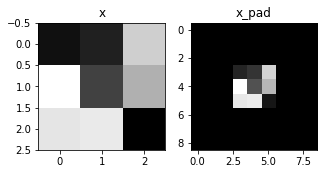

In [7]:
def zero_pad(X, pad):
  '''
  Give the dataset tensor of the shape (n_samples, n_h, n_w, n_channels), pad
  all images with a given pad.
  
  Argument:
  X -- ndarray of shape e (n_samples, n_h, n_w, n_channels)
  pad -- padding size

  Returns:
  X_pad -- padded dataset of shape
    (n_samples, n_h + 2*pad, n_w + 2*pad, n_channels)
  '''

  return np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant',
                constant_values=(0, 0))
  
# testing

x = np.random.rand(1, 3, 3, 1)
x_pad = zero_pad(x, pad=3)

fig, axes = plt.subplots(1, 2)

axes[0].set_title('x')
axes[0].imshow(x[0, :, :, 0])

axes[1].set_title('x_pad')
axes[1].imshow(x_pad[0, :, :, 0])

## Forward pass

In [9]:
def conv_single_step(a, W, b):
  '''
  Applies convolution for a and filter defined by W

  Arguments:
  a -- slice of input data of shape (f, f, n_C_prev)
  W -- weight matrix of shape (f, f, n_C_prev)
  b -- bias patameter

  Returns:
  Z -- scalar value, the result of one-step convolution
  '''

  Z = np.sum(np.multiply(a, W))
  return Z + np.squeeze(b)

In [11]:
def conv(A_prev, W, b, params={'pad' : 0, 'stride' : 1}):
  '''
  Computes convolution of A_pred with filter defined by W

  Arguments:
  A_prev -- activation tensor from the previous layer of shape
    (n_samples, n_h, n_w, n_channels)
  W -- weights, numpy array of shape (f, f, n_C_prev, n_C)
  b -- biases, numpy array of shape (1, 1, 1, n_C)
  params -- python dictionary containing 'pad' & 'stride' sizes

  Returns: 
  Z -- convolution output 
  cache -- information for backprop
  '''

  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
  (f, f, n_C_prev_check, n_C) = W.shape

  assert n_C_prev == n_C_prev_check # must be equal

  pad = params['pad']
  stride = params['stride']
  
  n_H = np.floor((n_H_prev + 2*pad - f)/stride) + 1
  n_W = np.floor((n_W_prev + 2*pad - f)/stride) + 1

  # output volume 
  Z = np.zeros((m, n_H, n_W, n_C))

  # Create A_prev_pad by padding A_prev
  A_prev_pad = zero_pad(A_prev, pad)

  for i in range(m):               # loop over the batch of training examples
    a_prev_pad = A_prev_pad[i]     # Select i-th training example's padded activation

    for h in range(n_H):           # loop over vertical axis of the output volume
      # Find the vertical start and end of the current "slice" (≈2 lines)
      vert_start = stride * h 
      vert_end = vert_start  + f
      
      for w in range(n_W):       # loop over horizontal axis of the output volume
        # Find the horizontal start and end of the current "slice" (≈2 lines)
        horiz_start = stride * w
        horiz_end = horiz_start + f
        
        for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                
          # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
          a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
          
          # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
          weights = W[:, :, :, c]
          biases  = b[:, :, :, c]
          Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

  # Save information in "cache" for the backprop
  cache = (A_prev, W, b, params)

  return Z, cache

## Pooling 

In [12]:
def pool_forward(A_prev, params, mode="max"):
  """
  Implements the forward pass of the pooling layer
  
  Arguments:
  A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
  params -- python dictionary containing "f" and "stride"
  mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
  
  Returns:
  A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
  cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
  """
  
  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

  f = params["f"]
  stride = params["stride"]

  n_H = np.floor(1 + (n_H_prev - f) / stride)
  n_W = np.floor(1 + (n_W_prev - f) / stride)
  n_C = n_C_prev
  
  A = np.zeros((m, n_H, n_W, n_C))              
  
  for i in range(m):                         # loop over the training examples
    a_prev_slice = A_prev[i]

    for h in range(n_H):                     # loop on the vertical axis of the output volume
      # Find the vertical start and end of the current "slice" (≈2 lines)
      vert_start = stride * h 
      vert_end = vert_start + f
      
      for w in range(n_W):                 # loop on the horizontal axis of the output volume
        # Find the vertical start and end of the current "slice" (≈2 lines)
        horiz_start = stride * w
        horiz_end = horiz_start + f
        
        for c in range (n_C):            # loop over the channels of the output volume
          
          # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
          a_slice_prev = a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c]
          
          # Compute the pooling operation on the slice. 
          # Use an if statement to differentiate the modes. 
          # Use np.max and np.mean.
          if mode == "max":
            A[i, h, w, c] = np.max(a_slice_prev)
          elif mode == "average":
            A[i, h, w, c] = np.mean(a_slice_prev)
          else:
            print(mode+ "-type pooling layer NOT Defined")    
  
  # Store the input and hparameters in "cache" for pool_backward()
  cache = (A_prev, params)
  
  # Making sure your output shape is correct
  assert(A.shape == (m, n_H, n_W, n_C))
  
  return A, cache

## Backpropagation

### Weights, biases

Forward pass: $ Z_{HW} = [X_{HW} * W + b_C] $

$ L = f(Z_{00}, ..., Z_{HW}); \frac{\partial{Z_{HW}}}{\partial{b_C}} = 1 $

For each channel: $ db_C = \sum_{h}\sum_{w}dZ_{HW} $

In [ ]:
def conv_backward(dZ, cache):
  '''
  Backward propagation for a convolution function
  
  Arguments:
  dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
  cache -- cache of values needed for the conv_backward(), output of conv()
  
  Returns:
  dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
              numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
  dW -- gradient of the cost with respect to the weights of the conv layer (W)
        numpy array of shape (f, f, n_C_prev, n_C)
  db -- gradient of the cost with respect to the biases of the conv layer (b)
        numpy array of shape (1, 1, 1, n_C)
  '''

  (A_prev, W, b, params) = cache
  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
  (f, f, n_C_prev_check, n_C) = W.shape

  assert n_C_prev == n_C_prev_check
  
  pad = params["pad"]
  stride = params["stride"]
  
  (m, n_H, n_W, n_C) = dZ.shape
  
  # Initialize dA_prev, dW, db with the correct shapes
  dA_prev = np.zeros(A_prev.shape)                          
  dW = np.zeros(W.shape)
  db = np.zeros(b.shape) # b.shape = [1,1,1,n_C]
  
  # Pad A_prev and dA_prev
  A_prev_pad = zero_pad(A_prev, pad)
  dA_prev_pad = zero_pad(dA_prev, pad)
  
  for i in range(m):                   # loop over the training examples
      
    # select ith training example from A_prev_pad and dA_prev_pad
    a_prev_pad = A_prev_pad[i]
    da_prev_pad = dA_prev_pad[i]
    
    for h in range(n_H):               # loop over vertical axis of the output volume
      for w in range(n_W):             # loop over horizontal axis of the output volume
        for c in range(n_C):           # loop over the channels of the output volume
            
          # Find the corners of the current "slice"
          vert_start = stride * h 
          vert_end = vert_start + f
          horiz_start = stride * w
          horiz_end = horiz_start + f

          # Use the corners to define the slice from a_prev_pad
          a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

          # Update gradients for the window and the filter's parameters using the code formulas given above
          da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
          dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
          db[:,:,:,c] += dZ[i, h, w, c]
                
    # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
    dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
  
  # Making sure your output shape is correct
  assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
  
  return dA_prev, dW, db

### Pooling 

#### Max Pool

In [ ]:
# masks max element in the matrix

def create_mask_from_window(x):

  return x == np.max(x)

#### Average Pool

In [13]:
def distribute_value(dz, shape):
  # Retrieve dimensions from shape (≈1 line)
  (n_H, n_W) = shape
  
  # Compute the value to distribute on the matrix (≈1 line)
  average = np.prod(shape)
  
  # Create a matrix where every entry is the "average" value (≈1 line)
  a = (dz/average)*np.ones(shape)

  return a

In [14]:
def pool_backward(dA, cache, mode = "max"):
  """
  Implements the backward pass of the pooling layer
  
  Arguments:
  dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
  cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
  mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
  
  Returns:
  dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
  """
  # Retrieve information from cache (≈1 line)
  (A_prev, hparameters) = cache
  
  # Retrieve hyperparameters from "hparameters" (≈2 lines)
  stride = hparameters["stride"]
  f = hparameters["f"]
  
  # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
  m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
  m, n_H, n_W, n_C = dA.shape
  
  # Initialize dA_prev with zeros (≈1 line)
  dA_prev = np.zeros(A_prev.shape)
  
  for i in range(m): # loop over the training examples
      
    # select training example from A_prev (≈1 line)
    a_prev = A_prev[i,:,:,:]
    
    for h in range(n_H):               # loop on the vertical axis
      for w in range(n_W):             # loop on the horizontal axis
        for c in range(n_C):           # loop over the channels (depth)

          # Find the corners of the current "slice" (≈4 lines)
          vert_start  = h * stride
          vert_end    = h * stride + f
          horiz_start = w * stride
          horiz_end   = w * stride + f
          
          # Compute the backward propagation in both modes.
          if mode == "max":

            a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
            
            mask = create_mask_from_window( a_prev_slice )
            dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
            
          elif mode == "average":
            
            da = dA[i, h, w, c]
            shape = (f, f)
            dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)

  # Making sure your output shape is correct
  assert(dA_prev.shape == A_prev.shape)
  
  return dA_prev